<a href="https://colab.research.google.com/github/oreomcflurryyy/data-analysis/blob/main/boston_housing_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing packages
We import our standard libraries at this top
level.

In [48]:
!pip install ISLP
!pip install l0bnb
!pip install pygam

In [3]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from statsmodels.api import OLS
import statsmodels.api as sm
from statsmodels.stats.outliers_influence \
     import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

In [5]:
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from ISLP.models import sklearn_sm

In [6]:
from sklearn.model_selection import train_test_split
from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.base import clone
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler

In [47]:
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)

from l0bnb import fit_path

### Data handling

In [8]:
Boston = load_data("Boston")
Boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


### Analyzing the Dataset

This analysis aids in selecting the essential features and drawing meaningful conclusions about the various attributes.

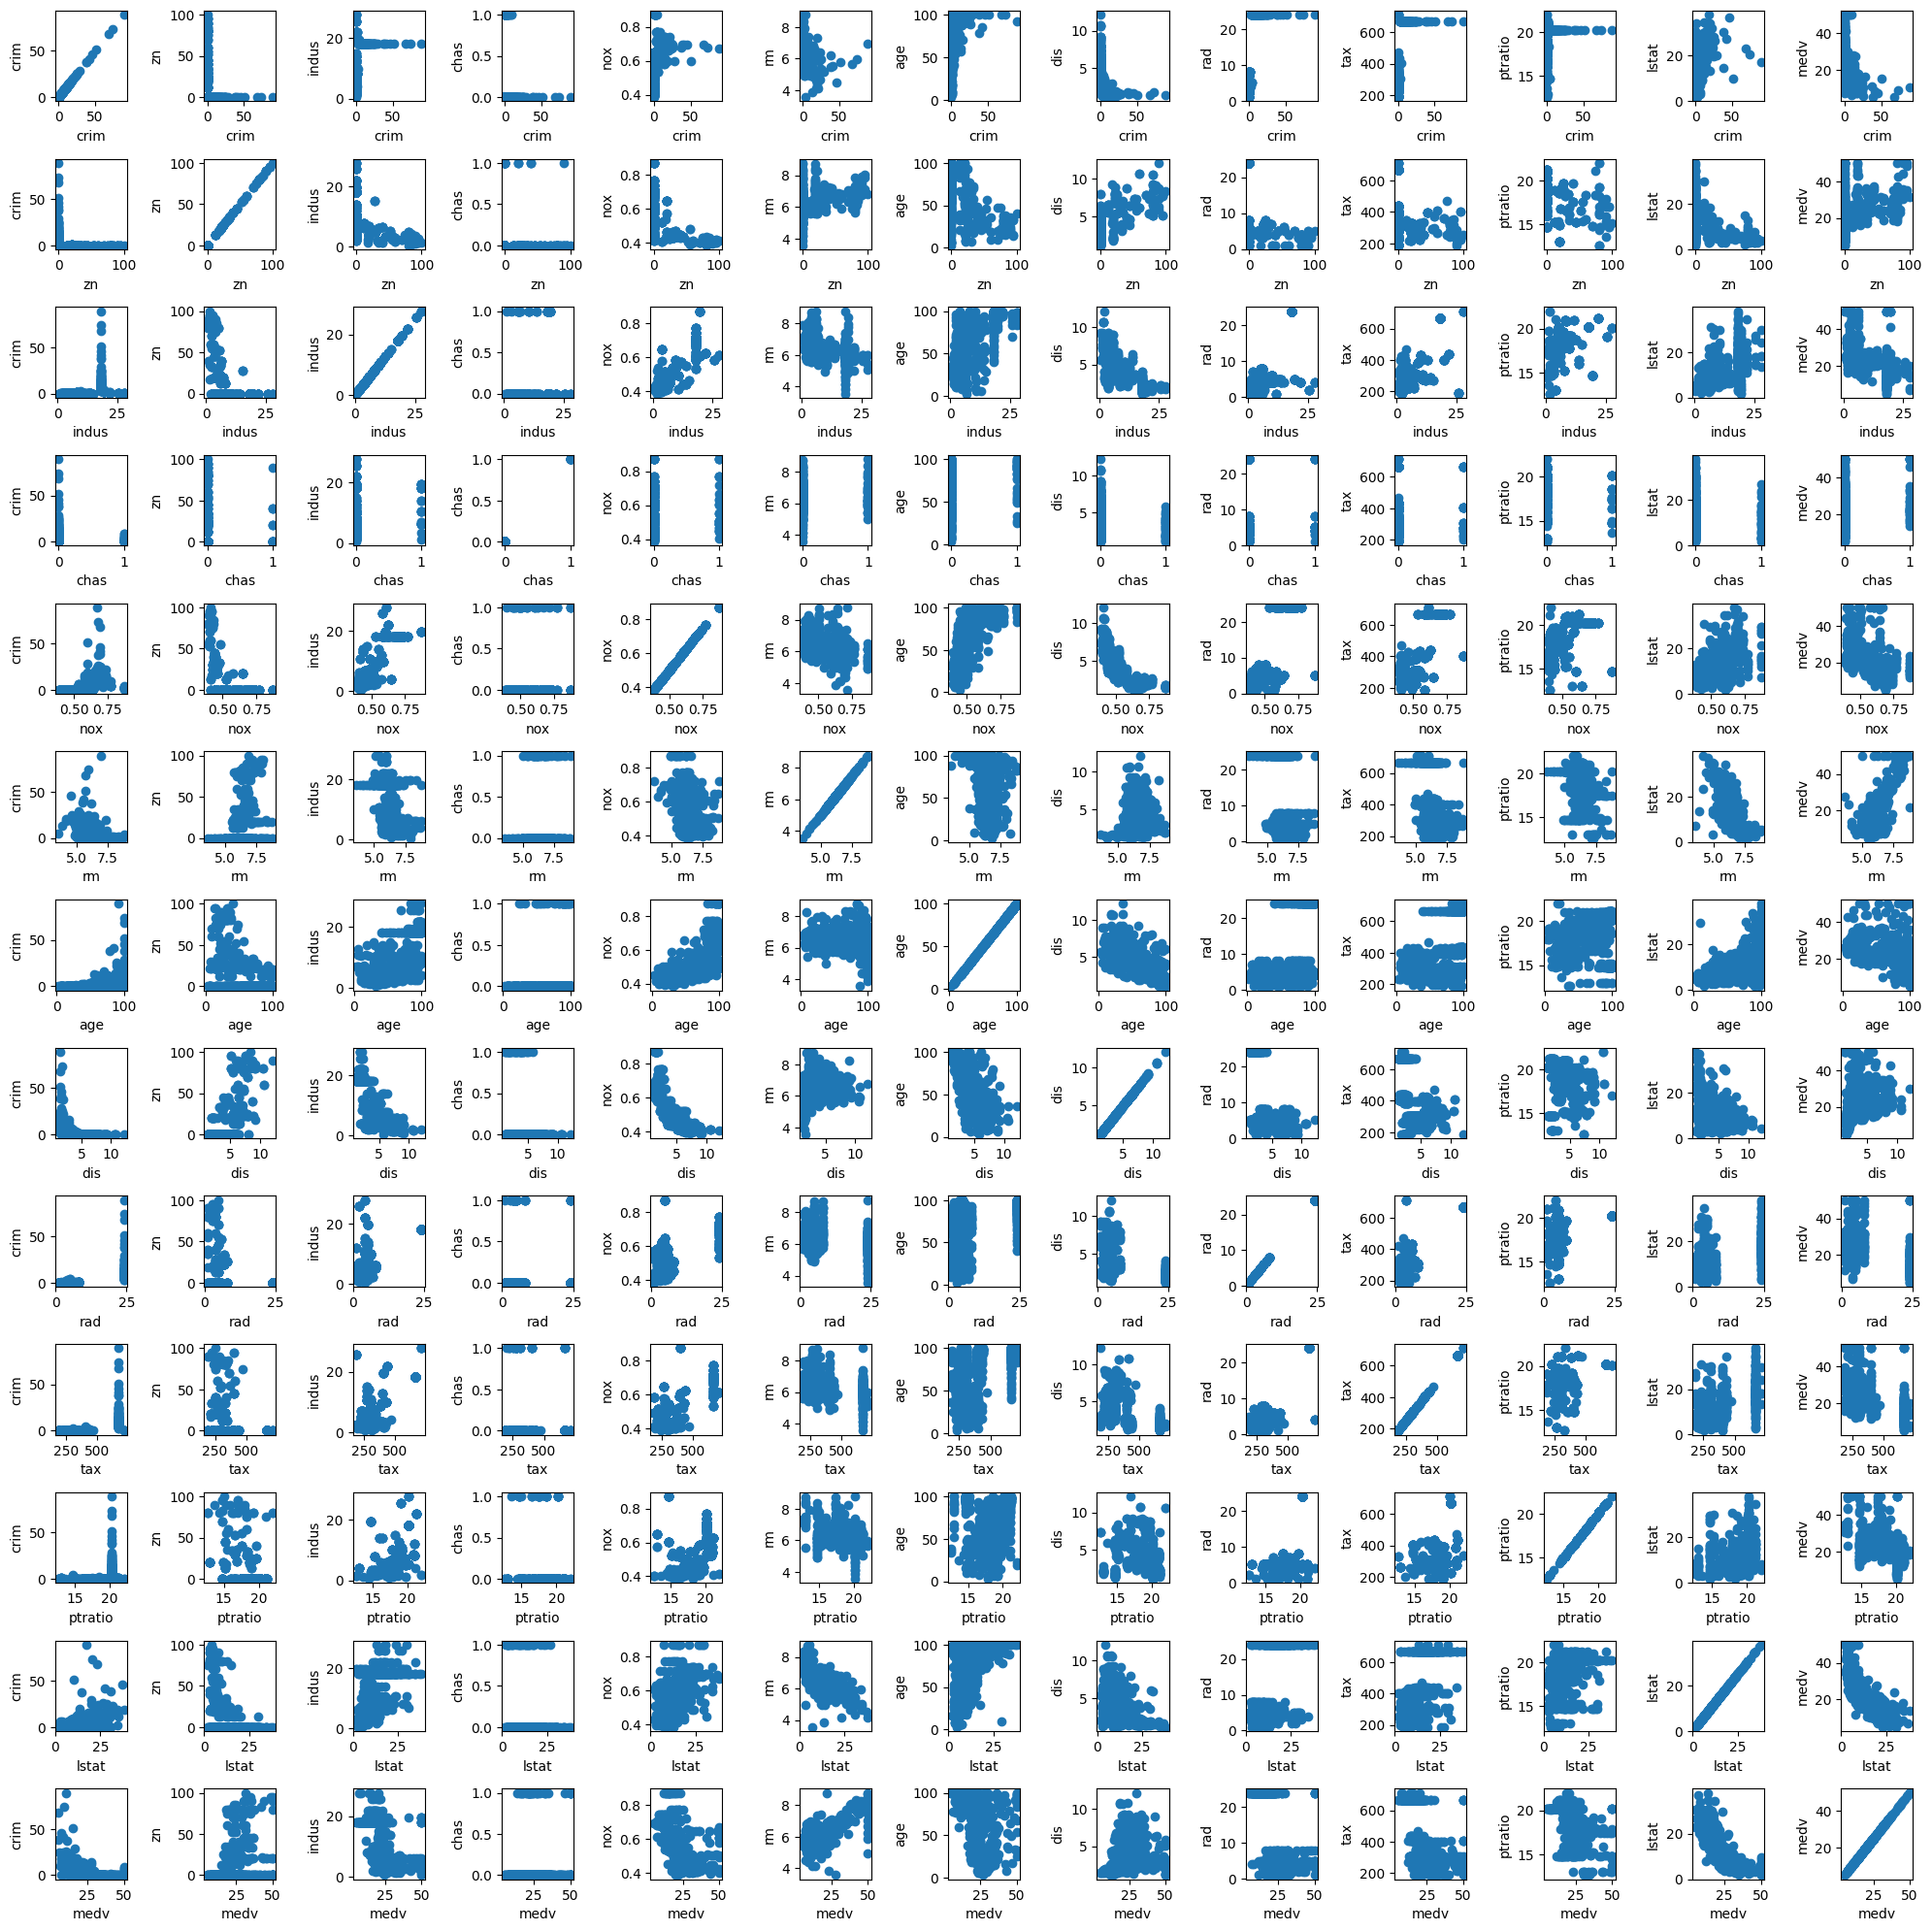

In [9]:
fig, axes = plt.subplots(nrows=len(Boston.columns), ncols=len(Boston.columns), figsize=(20, 20))

# Iterate through all possible pairs of columns
for i, col1 in enumerate(Boston.columns):
    for j, col2 in enumerate(Boston.columns):
      axes[i, j].scatter(Boston[col1], Boston[col2])  # Create scatter plot
      axes[i, j].set_xlabel(col1)  # Set x-axis label
      axes[i, j].set_ylabel(col2)  # Set y-axis label


plt.tight_layout()
plt.show()

###Observations from graphs :

- **CRIM (Per Capita Crime Rate):**
  - If `CRIM` is high, `MEDV` is low, and vice versa.

- **NOX (Nitric Oxides Concentration):**
  - If `NOX` is high, `MEDV` should be low.
  - There is likely a correlation between `NOX` and `INDUS` (Proportion of non-retail business acres per town).

- **RM (Average Number of Rooms per Dwelling):**
  - As expected, if `RM` is high, `MEDV` is also high, and vice versa.

- **AGE (Proportion of Owner-Occupied Units Built Prior to 1940) and DIST (Weighted Distances to Five Boston Employment Centres):**
  - There seems to be some correlation between `AGE` and `DIST`, but neither seems to affect `MEDV` significantly.

- **TAX (Full-Value Property Tax Rate per $10,000):**
  - Higher `TAX` shows lower `MEDV`.

- **LSTAT (Percentage of Lower Status of the Population):**
  - `LSTAT` shows an inverse regression with `MEDV`.




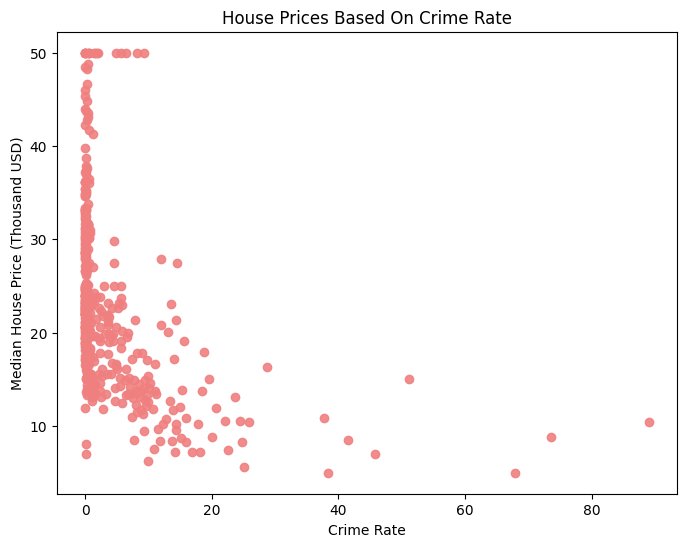

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(Boston['crim'], Boston['medv'], color='lightcoral', alpha=0.9)
plt.xlabel('Crime Rate')
plt.ylabel('Median House Price (Thousand USD)')
plt.title('House Prices Based On Crime Rate')
plt.show()

The inverse relationship is quite clear. When crime rates increase, average home prices tend to plummet. This makes sense because areas with high crime rates are often not attractive places to buy a home, leading to lower home prices.
In the areas with crime levels of 20% or more have very low house prices (under 10 thousand USD).


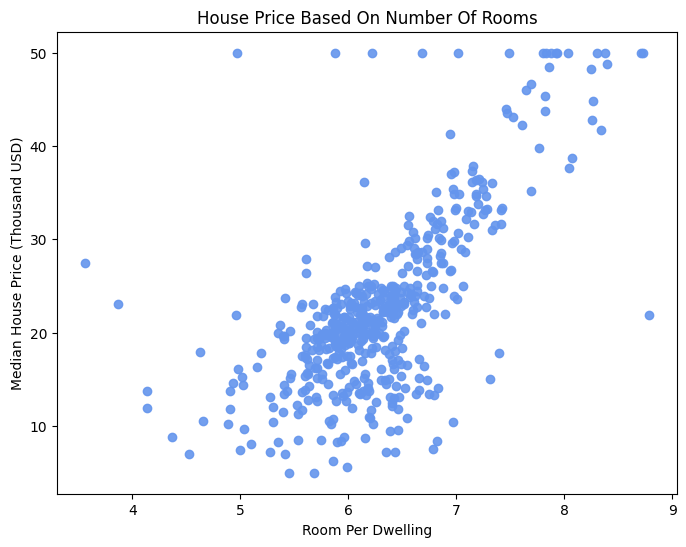

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(Boston['rm'], Boston['medv'], color='cornflowerblue', alpha=0.9)
plt.title('House Price Based On Number Of Rooms')
plt.xlabel('Room Per Dwelling')
plt.ylabel('Median House Price (Thousand USD)')
plt.show()

Positive relationship: The scatter plot shows that there is a positive relationship between the average number of rooms and the average house price. As the number of rooms increases, house prices also tend to increase. This makes sense because homes with more rooms tend to be larger in size and have a higher value.
- Data cluster: The majority of houses have 5 to 7 rooms and house prices range from about 15 to 35 thousand USD. This shows that this is a common price for average-sizehouses.



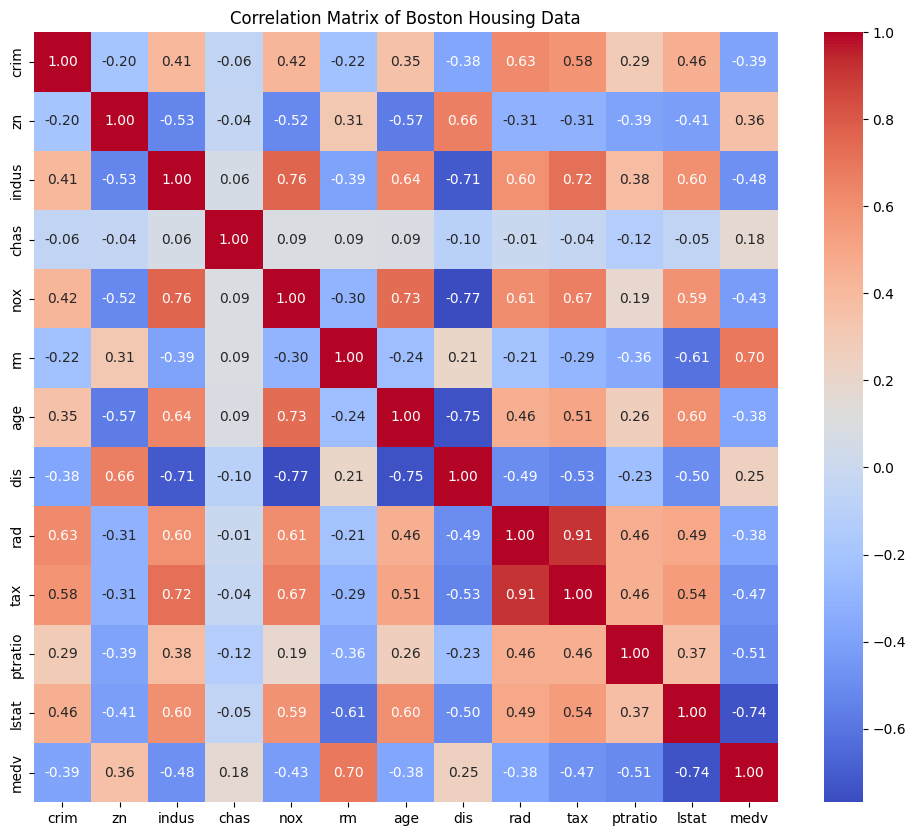

In [12]:
# Calculate the correlation matrix
correlation_matrix = Boston.corr()

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Boston Housing Data')
plt.show()

Regarding target variable MEDV, we find :-
*   RM and MEDV (0.70): The number of rooms per dwelling (RM) has a strong positive correlation with the median value of owner-occupied homes (MEDV). More rooms generally indicate higher home values.

*   LSTAT and MEDV (-0.74): The percentage of lower status of the population (LSTAT) has a strong negative correlation with MEDV. Higher LSTAT values are associated with lower home values.

Regarding other variables :-
*   INDUS and NOX (0.76): The proportion of non-retail business acres per town (INDUS) is strongly positively correlated with nitric oxides concentration (NOX). More industrial areas tend to have higher pollution levels.

*   TAX and INDUS (0.72): This indicates a strong positive relationship, meaning areas with higher industrial activity tend to have higher property tax rates.

*   TAX and RAD (0.91): The full-value property-tax rate per $10,000 (TAX) is strongly positively correlated with the index of accessibility to radial highways (RAD). Areas with higher taxes often have better highway access.

*   DIS and NOX (-0.77): The weighted distances to five Boston employment centers (DIS) is strongly negatively correlated with NOX. Greater distances from employment centers are associated with lower pollution levels.

*   AGE and DIS (-0.75): The proportion of owner-occupied units built prior to 1940 (AGE) is negatively correlated with DIS. Older homes tend to be closer to employment centers.

















### Linear Regression
We will build a regression model to predict  `medv`  using $1$
predictor which is `lstat`.

In [13]:
y = Boston['medv']
X = MS(['lstat']).fit_transform(Boston)
model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,34.5538,0.563,61.415,0.0
lstat,-0.9500,0.039,-24.528,0.0


In [14]:
def abline(ax, b, m, *args, **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

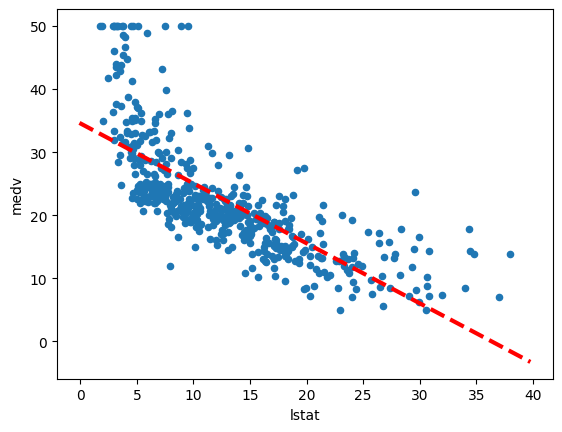

In [15]:
ax = Boston.plot.scatter('lstat', 'medv')
abline(ax,
       results.params.iloc[0],
       results.params.iloc[1],
       'r--',
       linewidth=3)

###Polynomial Regression
We will build a regression model with the second degree of `lstat` as a linear regression line above is not fitting the data well.

In [16]:
y = Boston['medv']
X = MS([poly('lstat', degree=2)]).fit(Boston)
model = sm.OLS(y, X.transform(Boston))
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,22.5328,0.246,91.761,0.0
"poly(lstat, degree=2)[0]",-152.4595,5.524,-27.601,0.0
"poly(lstat, degree=2)[1]",64.2272,5.524,11.628,0.0


In the code above, the first line executes the `fit()` method
using the dataframe
`Boston`. This recomputes and stores as attributes any parameters needed by `Poly()`
on the training data, and these will be used on all subsequent
evaluations of the `transform()` method. For example, it is used
on the second line, as well as in the plotting function developed below.

In [43]:
models = [MS([poly('lstat', degree=d)])
          for d in range(1, 6)]
Xs = [model.fit_transform(Boston) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()
           for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,504.0,19472.381418,0.0,NaN,NaN,NaN
1,503.0,15347.243158,1.0,4125.138260,151.692566,1.192917e-30
2,502.0,14615.481262,1.0,731.761897,26.908877,3.099865e-07
3,501.0,13967.690615,1.0,647.790646,23.821026,1.423298e-06
4,500.0,13597.035027,1.0,370.655588,13.630015,2.470868e-04


Notice the `*` in the `anova_lm()` line above. This
function takes a variable number of non-keyword arguments, in this case fitted models.
When these models are provided as a list (as is done here), it must be
prefixed by `*`.

The p-value comparing the linear `models[0]` to the quadratic
`models[1]` is essentially zero, indicating that a linear
fit is not sufficient. {Indexing starting at zero is confusing for the polynomial degree example, since `models[1]` is quadratic rather than linear!} Similarly the p-value comparing the quadratic
`models[1]` to the cubic `models[2]` is very low as well, so the
quadratic fit is also insufficient. The p-value comparing the cubic
and degree-four polynomials, `models[2]` and `models[3]`, is
approximately negligible, while the degree-five polynomial `models[4]` seems comparably unnecessary because its p-value is 0.0002. Hence, either a cubic or a quartic polynomial appear to provide a reasonable fit to the data, but
lower- or higher-order models are not justified.

We now create a grid of values for `lstat` at which we want
predictions.

In [17]:
lstat = Boston['lstat']
lstat_grid = np.linspace(lstat.min(),
                       lstat.max(),
                       100)
lstat_df = pd.DataFrame({'lstat': lstat_grid})

Finally, we wish to plot the data and add the fit from the second-degree polynomial. we first write a function
to create all the ingredients and produce the plot.  Our function
takes in a model specification (here a basis specified by a
transform), as well as a grid of `lstat` values. The function
produces a fitted curve as well as 95% confidence bands. By using
an argument for `basis` we can produce and plot the results with several different transforms.

In [18]:
def plot_medv_fit(lstat_df,
                  basis,
                  title):

    X = basis.transform(Boston)
    Xnew = basis.transform(lstat_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(lstat,
               y,
               facecolor='gray',
               alpha=0.5)
    for val, ls in zip([preds.predicted_mean,
                      bands[:,0],
                      bands[:,1]],
                     ['b','r--','r--']):
        ax.plot(lstat_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('lstat', fontsize=20)
    ax.set_ylabel('medv', fontsize=20);
    return ax

We include an argument `alpha` to `ax.scatter()`
to add some transparency to the points. This provides a visual indication
of density. Here `zip()` conveniently bundles these together as
iterators in the loop.

We now plot the fit of the fourth-degree polynomial using this
function.

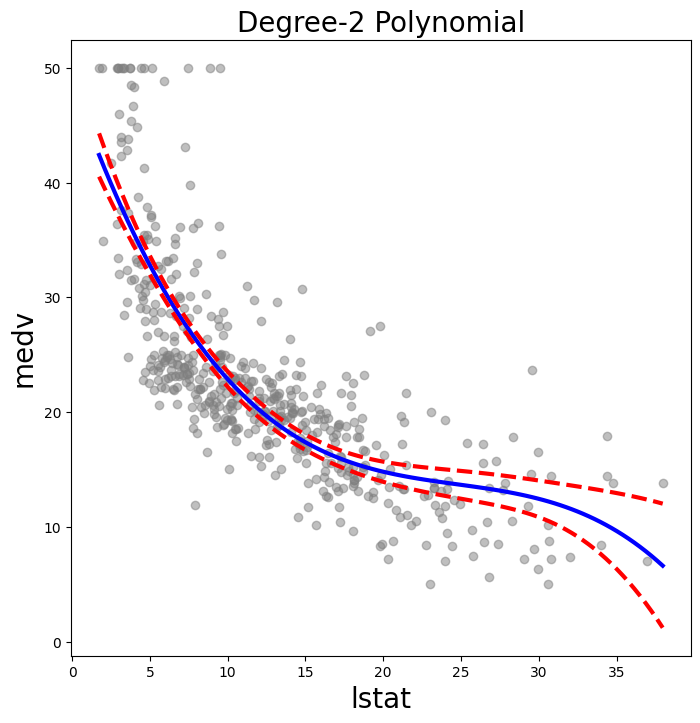

In [46]:
plot_medv_fit(lstat_df=lstat_df,
              basis=MS([poly('lstat', degree=3)]).fit(Boston),
              title='Degree-2 Polynomial');

### Splines
In order to fit regression splines, we use transforms
from the `ISLP` package. The actual spline
evaluation functions are in the `scipy.interpolate` package;
we have simply wrapped them as transforms
similar to `Poly()` and `PCA()`.

Regression splines can be fit by constructing an appropriate
matrix of basis functions.  The `BSpline()`  function generates the
entire matrix of basis functions for splines with the specified set of
knots. By default, the B-splines produced are cubic. To change the degree, use
the argument `degree`.

In [52]:
bs_lstat = MS([bs('lstat',
                  df=4,
                  name='bs(lstat)')])
Xbs = bs_lstat.fit_transform(Boston)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,50.0849,1.549,32.343,0.0
bs(lstat)[0],-24.3618,2.331,-10.450,0.0
bs(lstat)[1],-31.7814,1.927,-16.492,0.0
bs(lstat)[2],-44.4214,3.488,-12.735,0.0
bs(lstat)[3],-35.8306,3.092,-11.588,0.0


We could use the `df` (degrees of freedom) option to
specify the complexity of the spline.  We see above that with n knots,
the spline basis has 2n columns or degrees of freedom.  When we specify
`df=4` rather than the actual knots, `bs()` will produce a
spline with 4 knots chosen at uniform quantiles of the training data.
We can see these chosen knots most easily using `Bspline()` directly:

In [65]:
BSpline(df=6).fit(lstat).internal_knots_

array([ 6.95 , 11.36 , 16.955])

 When asking for six degrees of freedom,
the transform chooses knots at ages 33.75, 42.0, and 51.0,
which correspond to the 25th, 50th, and 75th percentiles of
`lstat`.

In order to fit a natural spline, we use the `NaturalSpline()`
transform with the corresponding helper `ns()`.  Here we fit a natural spline with five
degrees of freedom (excluding the intercept) and plot the results.

In [62]:
ns_lstat = MS([ns('lstat', df=4)]).fit(Boston)
M_ns = sm.OLS(y, ns_lstat.transform(Boston)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,47.7340,1.285,37.146,0.0
"ns(lstat, df=4)[0]",-25.0924,1.280,-19.609,0.0
"ns(lstat, df=4)[1]",-28.2503,1.440,-19.613,0.0
"ns(lstat, df=4)[2]",-58.0167,3.089,-18.780,0.0
"ns(lstat, df=4)[3]",-23.5395,2.079,-11.322,0.0


We now plot the natural spline using our plotting function.

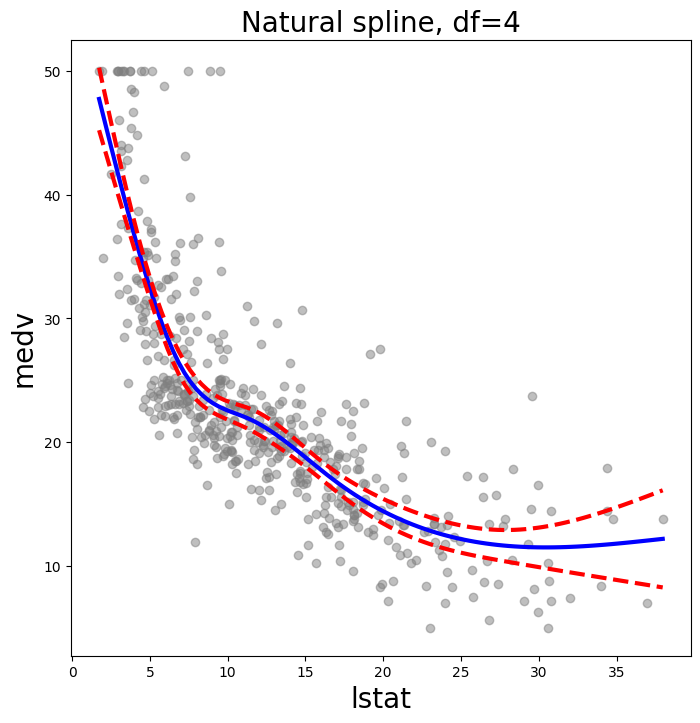

In [63]:
plot_medv_fit(lstat_df,
              ns_lstat,
              'Natural spline, df=4');

### Smoothing Splines and GAMs
A smoothing spline is a special case of a GAM with squared-error loss
and a single feature. To fit GAMs in `Python` we will use the
`pygam` package which can be installed via `pip install pygam`. The
estimator `LinearGAM()` uses squared-error loss.
The GAM is specified by associating each column
of a model matrix with a particular smoothing operation:
`s` for smoothing spline; `l` for linear, and `f` for factor or categorical variables.
The argument `0` passed to `s` below indicates that this smoother will
apply to the first column of a feature matrix. Below, we pass it a
matrix with a single column: `X_age`. The argument `lam` is the penalty parameter $\lambda$.

In [64]:
lstat = Boston['lstat']
X_lstat = np.asarray(lstat).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_lstat, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

Let’s investigate how the fit changes with the smoothing parameter `lam`.
The function `np.logspace()` is similar to `np.linspace()` but spaces points
evenly on the log-scale. Below we vary `lam` from $10^{-2}$ to $10^6$.

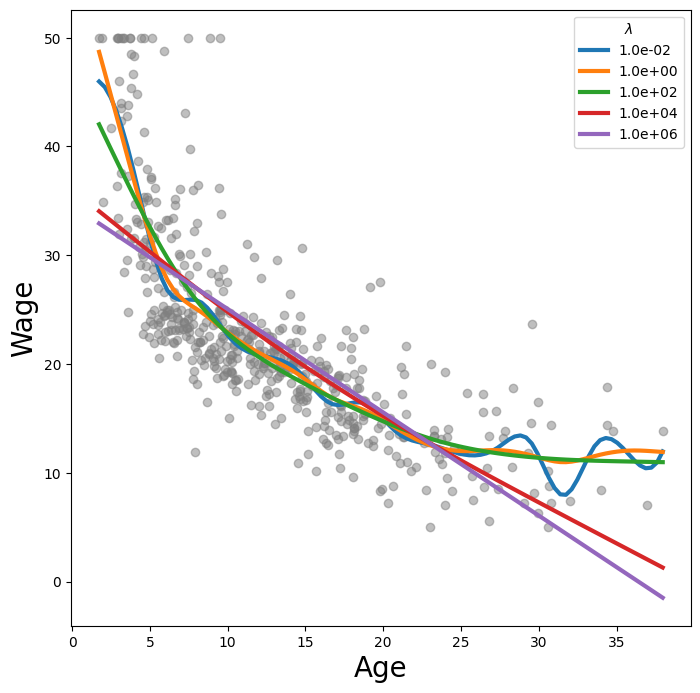

In [66]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(lstat, y, facecolor='gray', alpha=0.5)
for lam in np.logspace(-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_lstat, y)
    ax.plot(lstat_grid,
            gam.predict(lstat_grid),
            label='{:.1e}'.format(lam),
            linewidth=3)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='$\lambda$');

The `pygam` package can perform a search for an optimal smoothing parameter.

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


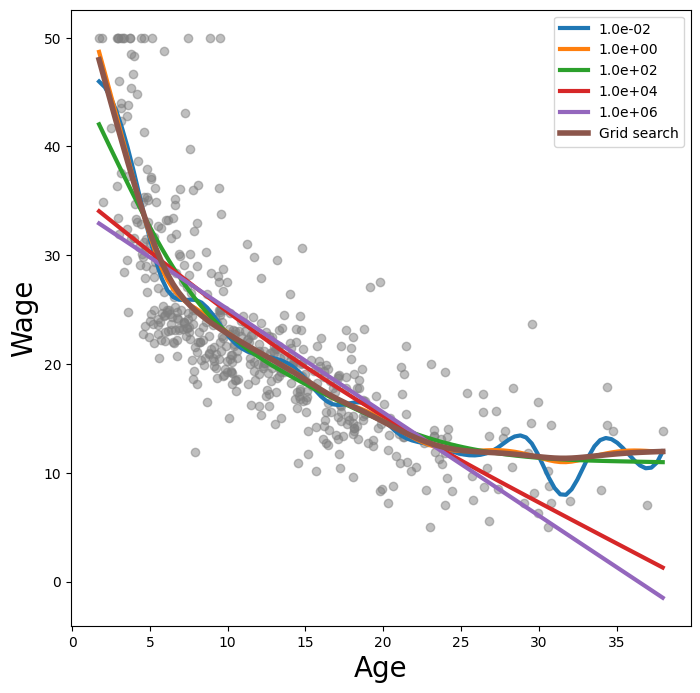

In [68]:
gam_opt = gam.gridsearch(X_lstat, y)
ax.plot(lstat_grid,
        gam_opt.predict(lstat_grid),
        label='Grid search',
        linewidth=4)
ax.legend()
fig

### The Validation Set Approach
We explore the use of the validation set approach in order to estimate
the test error rates that result from fitting various linear models on
the  `Boston`  data set.

We use the function `train_test_split()` to split
the data into training and validation sets. As there are 506 observations,
we split into two equal sets of size 253 using the
argument `test_size=253`. It is generally a good idea to set a random seed
when performing operations like this that contain an
element of randomness, so that the results obtained can be reproduced
precisely at a later time. We set the random seed of the splitter
with the argument `random_state=0`.

In [20]:
Boston_train, Boston_valid = train_test_split(Boston,
                                         test_size=253,
                                         random_state=0)

### Simple Univariate/Multivariate/Polynomial Regression
In this section we will  construct model
matrices (also called design matrices) using the `ModelSpec()`  transform from `ISLP.models`.

We  will use the `Boston` housing data set, which is contained in the `ISLP` package.  The `Boston` dataset records  `medv`  (median house value) for $506$ neighborhoods
around Boston.  We will build a regression model to predict  `medv`  using $13$
predictors.

In [21]:
terms = Boston_train.columns.drop('medv')
terms.shape

(12,)

In [22]:
y_train = Boston_train['medv']
X_train = MS(terms).fit_transform(Boston_train)
model = sm.OLS(y_train, X_train)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,45.1670,6.993,6.459,0.000
crim,-0.1190,0.041,-2.915,0.004
zn,0.0582,0.018,3.322,0.001
indus,0.0705,0.085,0.826,0.409
chas,3.5119,1.178,2.981,0.003
nox,-17.1464,5.349,-3.206,0.002
rm,3.5003,0.569,6.147,0.000
age,-0.0014,0.018,-0.081,0.935
dis,-1.5854,0.274,-5.779,0.000
rad,0.2349,0.086,2.729,0.007


Here, we exclude indus and age because it not factored well in the model. Also, let us factor in the interactions of indus : nox or tax : indus or tax : rad or age : dist in the models and compare.

In [23]:
X_train1 = MS(['crim', 'rm', 'ptratio', 'lstat', ('age', 'dis')]).fit_transform(Boston_train)
model1 = sm.OLS(y_train, X_train1)
results1 = model1.fit()
summarize(results1)

,coef,std err,t,P>|t|
intercept,22.5282,5.503,4.094,0.000
crim,-0.0996,0.040,-2.481,0.014
rm,4.7198,0.571,8.264,0.000
ptratio,-1.0844,0.160,-6.791,0.000
lstat,-0.5343,0.063,-8.511,0.000
age:dis,-0.0104,0.003,-3.107,0.002


In [24]:
X_train2 = MS(['crim', 'rm', poly('lstat', degree=2)]).fit_transform(Boston_train)
model2 = sm.OLS(y_train, X_train2)
results2 = model2.fit()
summarize(results2)

,coef,std err,t,P>|t|
intercept,-7.7229,3.353,-2.303,0.022
crim,-0.1532,0.037,-4.132,0.000
rm,4.9637,0.532,9.334,0.000
"poly(lstat, degree=2)[0]",-69.4479,6.735,-10.312,0.000
"poly(lstat, degree=2)[1]",44.7301,4.812,9.296,0.000


In [25]:
X_train3 = MS(['crim', 'rm', 'lstat']).fit_transform(Boston_train)
model3 = sm.OLS(y_train, X_train3)
results3 = model3.fit()
summarize(results3)

,coef,std err,t,P>|t|
intercept,-4.7766,4.412,-1.083,0.280
crim,-0.1128,0.043,-2.643,0.009
rm,5.6304,0.611,9.221,0.000
lstat,-0.5922,0.069,-8.614,0.000


In [26]:
anova_lm(results1, results, results3, results2,)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,247.0,6024.492923,0.0,NaN,NaN,NaN
1,240.0,5018.994824,7.0,1005.498100,6.439195,5.862371e-07
2,249.0,7460.036550,-9.0,-2441.041726,12.158530,NaN
3,248.0,5532.269384,1.0,1927.767166,86.417747,7.823513e-18


Randomly chosen models seems to be working well with respect to each other. We find, `model` is better than `model1`. Which works similarly for `model3`, that is `model2` is the more efficient.

This provides very clear evidence that the quadratic polynomial in `lstat` improves the linear model.
This is not surprising, since earlier we saw evidence for non-linearity in the relationship between `medv`
and  `lstat`.

We now use the `predict()` method of `results2` and `result` evaluated on the model matrix for this model
created using the validation data set. We also calculate the validation MSE of our model.

In [27]:
X_valid = MS(terms).fit_transform(Boston_valid)
X_valid2 = MS(['crim', 'rm', poly('lstat', degree=2)]).fit_transform(Boston_valid)
y_valid = Boston_valid['medv']

valid_pred = results.predict(X_valid)
valid_pred2 = results2.predict(X_valid2)
print(np.mean((y_valid - valid_pred)**2), ",", np.mean((y_valid - valid_pred2)**2))

26.105557305802705 , 28.03356876637101


### Forward Selection

We will  apply the forward-selection approach to the  `Boston`
data.  We wish to predict a median value of housing `medv` on the
basis of various statistics associated with prices, to include only the most needed predictors.

We first choose the best model using forward selection based on $C_p$. This score
is not built in as a metric to `sklearn`. We therefore define a function to compute it ourselves, and use
it as a scorer. By default, `sklearn` tries to maximize a score, hence
  our scoring function  computes the negative $C_p$ statistic.

In [28]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

We need to estimate the residual variance $\sigma^2$, which is the first argument in our scoring function above.
We will fit the biggest model, using all the variables, and estimate $\sigma^2$ based on its MSE.

In [29]:
design = MS(Boston_train.columns.drop('medv')).fit(Boston_train)
Y = np.array(Boston_train['medv'])
X = design.transform(Boston_train)
sigma2 = OLS(Y,X).fit().scale

The function `sklearn_selected()` expects a scorer with just three arguments --- the last three in the definition of `nCp()` above. We use the function `partial()` to freeze the first argument with our estimate of $\sigma^2$.

In [30]:
neg_Cp = partial(nCp, sigma2)

We can now use `neg_Cp()` as a scorer for model selection.

Along with a score we need to specify the search strategy. This is done through the object
`Stepwise()`  in the `ISLP.models` package. The method `Stepwise.first_peak()`
runs forward stepwise until any further additions to the model do not result
in an improvement in the evaluation score.

In [31]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

We now fit a linear regression model with `Salary` as outcome using forward
selection. To do so, we use the function `sklearn_selected()`  from the `ISLP.models` package. This takes
a model from `statsmodels` along with a search strategy and selects a model with its
`fit` method. Without specifying a `scoring` argument, the score defaults to MSE, and so all 12 variables will be
selected.

Using `neg_Cp` results in a smaller model, as expected, with just 10 variables selected.

In [32]:
boston_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring=neg_Cp)
boston_Cp.fit(Boston_train, Y)
boston_Cp.selected_state_

('chas', 'crim', 'dis', 'lstat', 'nox', 'ptratio', 'rad', 'rm', 'tax', 'zn')

In [33]:
design_valid = MS(Boston_valid.columns.drop('medv')).fit(Boston_valid)
Y_valid = np.array(Boston_valid['medv'])
X_valid = design_valid.transform(Boston_valid)
Y_pred = boston_Cp.predict(Boston_valid)

# np.mean((Y_valid - Y_pred)**2)
boston_Cp.score(X_valid, Y_valid)

25.96159527782237

We find that the MSE is *lowest* for the model selected by `forward selection`, than those model parameters selected manually.

### Choosing Among Models Using the Validation Set Approach and Cross-Validation

As an  alternative to using $C_p$, we might try cross-validation to select a model in forward selection. For this, we need a
method that stores the full path of models found in forward selection, and allows predictions for each of these. This can be done with the `sklearn_selection_path()`
estimator from `ISLP.models`. The function `cross_val_predict()` from `ISLP.models`
computes the cross-validated predictions for each of the models
along the path, which we can use to evaluate the cross-validated MSE
along the path.

Here we define a strategy that fits the full forward selection path.
While there are various parameter choices for `sklearn_selection_path()`,
we use the defaults here, which selects the model at each step based on the biggest reduction  in RSS.

In [34]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
full_path = sklearn_selection_path(OLS, strategy)

We now fit the full forward-selection path on the `Boston_train` data and compute the fitted values.

In [35]:
full_path.fit(Boston_train, Y)
Yhat_in = full_path.predict(Boston_train)
Yhat_in.shape

(253, 13)

In [36]:
Y.shape

(253,)

This gives us an array of fitted values --- 13 steps in all, including the fitted mean for the null model --- which we can use to evaluate
in-sample MSE. As expected, the in-sample MSE improves each step we take,
indicating we must use either the validation or cross-validation
approach to select the number of steps. We fix the y-axis to compare to the cross-validation and validation
set MSE below, as well as other methods such as ridge regression, lasso and
principal components regression.

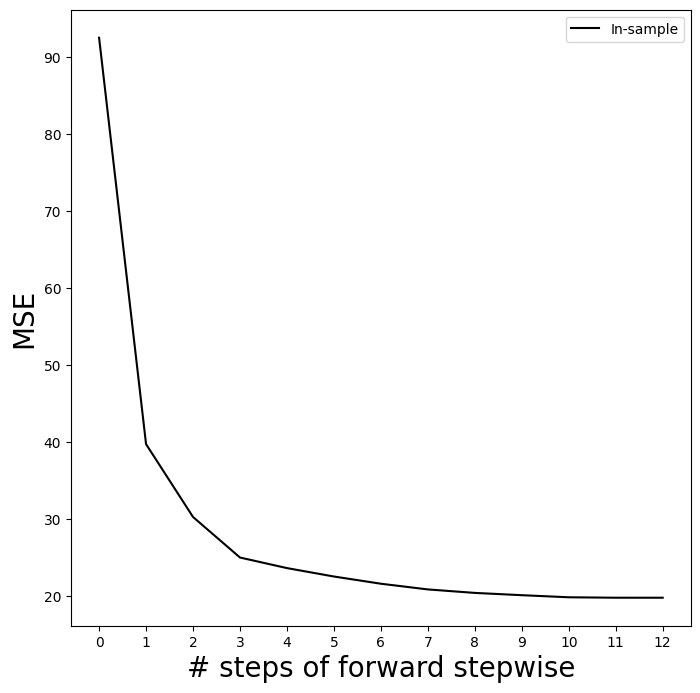

In [37]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k',
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps))
ax.legend()

We are now ready to use cross-validation to estimate test error along
the model path. We must use *only the training observations* to perform all aspects of model-fitting --- including
variable selection.  Therefore, the determination of which model of a
given size is best must be made using **only the training
  observations** in each training fold. This point is subtle but important.  If the full data
set is used to select the best subset at each step, then the validation
set errors and cross-validation errors that we obtain will not be
accurate estimates of the test error.

We now compute the cross-validated predicted values using 5-fold cross-validation.

In [38]:
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path,
                                Boston_train,
                                Y,
                                cv=kfold)
Yhat_cv.shape

(253, 13)

`skm.cross_val_predict()`
The prediction matrix `Yhat_cv` is the same shape as `Yhat_in`; the difference is that the predictions in each row, corresponding to a particular sample index, were made from models fit on a training fold that did not include that row.

At each model along the path, we compute the MSE in each of the cross-validation folds.
These we will average to get the  mean MSE, and can also use the individual values to compute a crude estimate of the standard error of the mean.

Hence we must know the test indices for each cross-validation
split. This can be found by using the `split()` method of `kfold`. Because
we  fixed the random state above, whenever we split any array with the same
number of rows as $Y$ we recover the same training and test indices, though we simply
ignore the training indices below.

In [39]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(13, 5)

We now add the cross-validation error estimates to our MSE plot.
We include the mean error across the five folds, and the estimate of the standard error of the mean.

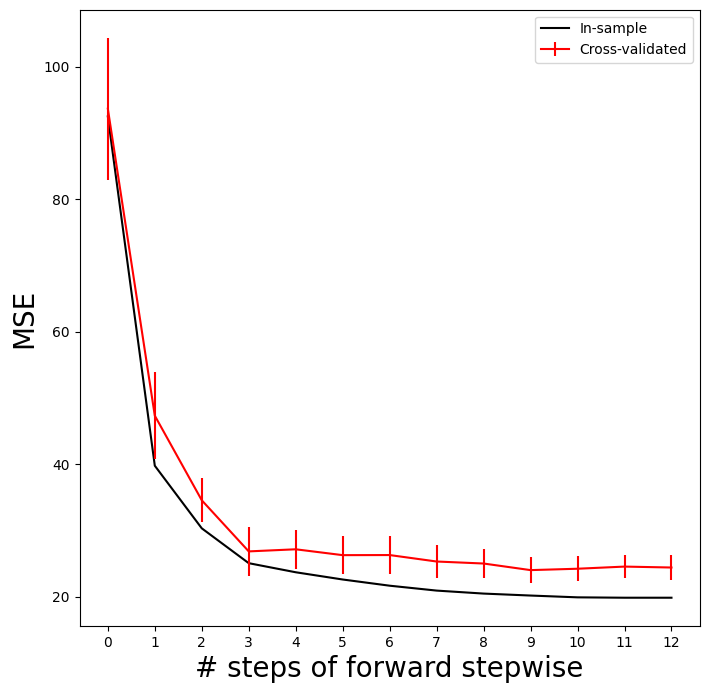

In [40]:
ax.errorbar(np.arange(n_steps),
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r')
ax.legend()
mse_fig

MSE error for training set is minimized at 10,
though there is little noticable difference between this point and a much higher number as plot estimates constantly. MSE has regressed into lower values with increase in the number of predictors.



Let us look into the fitted model by testing it on the testing set.

In [41]:
Y_pred = full_path.predict(X_valid)
Y_pred.shape

(253, 13)

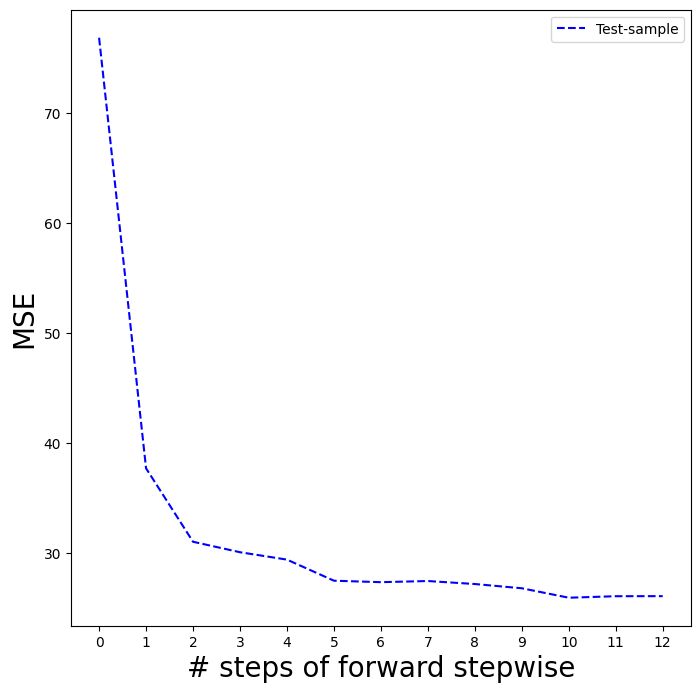

In [42]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Y_pred - Y_valid[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'b--',
        label='Test-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps))
ax.legend()

## Final Conclusion

The optimal model for the Boston Housing dataset utilizes 10 predictors. However, the analysis shows negligible changes in MSE (Mean Squared Error) when using more than 10 predictors. Since the number of observations (n) is greater than the number of predictors (p), a simple multivariate regression using all available predictors proves sufficient, consistently yielding MSE values between 25-30.